In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random
import sys
import seaborn as sns
from matplotlib.image import imread
import cv2

In [2]:
train_path='train'
test_path='test'

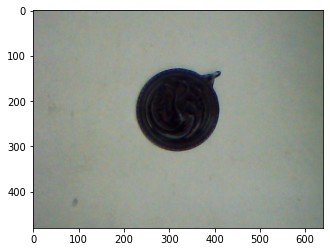

In [3]:
img=imread(train_path+'/circle/'+os.listdir(train_path+'/circle')[4])
plt.imshow(img,cmap='gray')

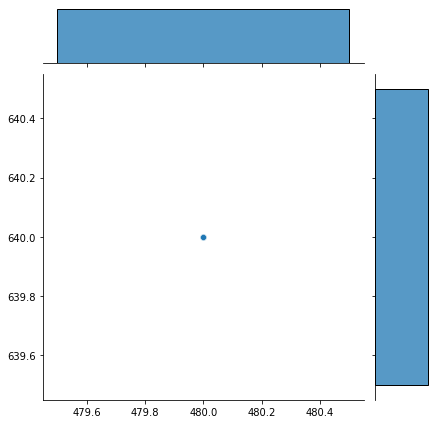

In [4]:
dim1 = []
dim2 = []
for image_filename in os.listdir(train_path+'/circle'):
    img = imread(train_path+'/circle'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)
sns.jointplot(x=dim1,y=dim2)

In [5]:
img.shape

(480, 640, 3)

In [6]:
len(os.listdir(train_path))

3

In [7]:
len(os.listdir(test_path))

3

In [8]:
image_shape = (480, 640, 3)

In [9]:
classes=['irregular','circle','rectangle']
print(classes)

['irregular', 'circle', 'rectangle']


In [10]:
data=0
total=0
for c in classes:
    for image_filename in os.listdir(train_path+'/'+str(c)):
        total+=1
        data+=1       
    
    print("Total number of images = ",data, "in class =",c)
    data=0

print("Total images = ",total)
print("Average no images = ",total//3)

Total number of images =  24 in class = irregular
Total number of images =  24 in class = circle
Total number of images =  24 in class = rectangle
Total images =  72
Average no images =  24


Data Agumentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [12]:
image_gen = ImageDataGenerator(rotation_range=0, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.05, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.05, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

batch_size = 32

In [13]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               #save_to_dir='preview',
                                               #save_prefix='train',
                                               #save_format='png',
                                               shuffle=True)

len(train_image_gen.classes)

Found 72 images belonging to 3 classes.


72

In [14]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               #save_to_dir='preview',
                                               #save_prefix='test',
                                               #save_format='png',
                                               shuffle=False)

print(len(test_image_gen.classes))
print(train_image_gen.class_indices)

Found 18 images belonging to 3 classes.
18
{'Irregular': 0, 'circle': 1, 'rectangle': 2}


Model Creation and training

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from keras import Sequential
from tensorflow.keras import regularizers
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from keras.optimizers import SGD
from keras.models import load_model
import tensorflow as tf

In [16]:
"""base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, 
                                                             weights="imagenet",
                                                             input_shape=image_shape,
                                                             pooling='max')
for layer in base_model.layers:
    layer.trainable = False

model=Sequential()
model.add(base_model)
#model.add(layers.Dense(128))
#model.add(layers.Activation('relu'))
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dense(8))
model.add(layers.Activation('relu'))

model.add(layers.Dense(len(classes),'softmax'))
"""

'base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, \n                                                             weights="imagenet",\n                                                             input_shape=image_shape,\n                                                             pooling=\'max\')\nfor layer in base_model.layers:\n    layer.trainable = False\n\nmodel=Sequential()\nmodel.add(base_model)\n#model.add(layers.Dense(128))\n#model.add(layers.Activation(\'relu\'))\nmodel.add(layers.Dense(64))\nmodel.add(layers.Activation(\'relu\'))\nmodel.add(layers.Dense(8))\nmodel.add(layers.Activation(\'relu\'))\n\nmodel.add(layers.Dense(len(classes),\'softmax\'))\n'

In [17]:
"""
base_model = ResNet152V2(input_shape=image_shape ,
                            include_top=False,
                            weights='imagenet',
                            pooling='avg'
                           )

for layer in base_model.layers:
    layer.trainable = False

model=Sequential()
model.add(base_model)
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))

"""

"\nbase_model = ResNet152V2(input_shape=image_shape ,\n                            include_top=False,\n                            weights='imagenet',\n                            pooling='avg'\n                           )\n\nfor layer in base_model.layers:\n    layer.trainable = False\n\nmodel=Sequential()\nmodel.add(base_model)\nmodel.add(Dense(128,activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(len(classes), activation='softmax'))\n\n"

In [18]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,kernel_size= (3,3),input_shape=image_shape ,activation='relu' )) 
model.add(layers.MaxPool2D(pool_size= (2,2))) 

model.add(layers.Conv2D(filters=16,kernel_size= (3,3) ,activation='relu' )) 
model.add(layers.MaxPool2D(pool_size= (2,2))) 

"""model.add(layers.Conv2D(filters=8,kernel_size= (3,3) ,activation='relu')) 
model.add(layers.MaxPool2D(pool_size= (2,2)))

model.add(layers.Conv2D(filters=16,kernel_size= (3,3) ,activation='relu' )) 
model.add(layers.MaxPool2D(pool_size= (2,2)))

model.add(layers.Conv2D(filters=32,kernel_size= (3,3) ,activation='relu' )) 
model.add(layers.MaxPool2D(pool_size= (2,2)))"""


model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(layers.Activation('relu'))
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dense(128))
model.add(layers.Activation('relu'))

model.add(layers.Dense(len(classes),'softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 638, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 239, 319, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 118, 158, 16)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 298304)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [20]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

c:\Users\vince\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [21]:
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5, min_lr=0.0001)

In [22]:
history = model.fit(train_image_gen,epochs=20,validation_data=test_image_gen,
                    callbacks=[learning_rate_reduction]
                    )

Epoch 1/20
3/3 [==============================] - 11s 2s/step - loss: 1.5773 - accuracy: 0.2639 - val_loss: 1.0869 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 1.1451 - accuracy: 0.3472
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3/3 [==============================] - 5s 2s/step - loss: 1.1451 - accuracy: 0.3472 - val_loss: 1.1288 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 5s 2s/step - loss: 1.0963 - accuracy: 0.4722 - val_loss: 0.9792 - val_accuracy: 0.6667 - lr: 5.0000e-04
Epoch 4/20
3/3 [==============================] - 6s 3s/step - loss: 1.0035 - accuracy: 0.5000 - val_loss: 0.9014 - val_accuracy: 0.5556 - lr: 5.0000e-04
Epoch 5/20
3/3 [==============================] - 5s 2s/step - loss: 0.9625 - accuracy: 0.5139 - val_loss: 0.8170 - val_accuracy: 0.6111 - lr: 5.0000e-04
Epoch 6/20
3/3 [==============================] - 5s 2s/step - loss: 0.8805 - ac

In [23]:

metrics = pd.DataFrame(model.history.history)


<AxesSubplot:>

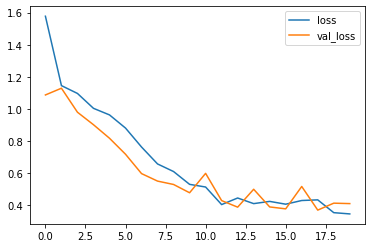

In [24]:

metrics[['loss','val_loss']].plot()

<AxesSubplot:>

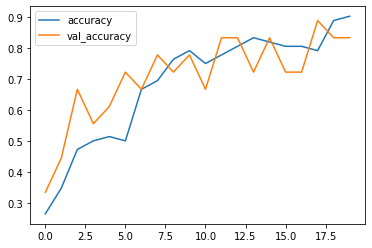

In [25]:

metrics[['accuracy','val_accuracy']].plot()


In [26]:

predictions = np.argmax(model.predict(test_image_gen), axis=1)


1/1 [==============================] - 1s 1s/step


In [27]:

print(classification_report(test_image_gen.classes,predictions))

print(confusion_matrix(test_image_gen.classes,predictions))


              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         6

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18

[[5 1 0]
 [0 6 0]
 [0 0 6]]


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

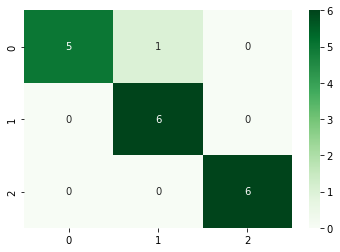

In [29]:
cm=confusion_matrix(test_image_gen.classes,predictions)
sns.heatmap(cm,annot=True,cmap="Greens")

In [30]:

#model.save('test.h5')


Output

1/1 [==============================] - 0s 409ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0. 1. 0.]]
1
circle


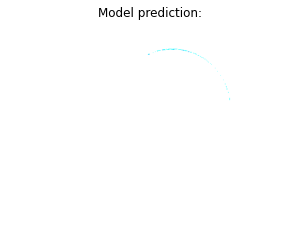

In [31]:
import random
import tensorflow as tf

para_img= imread('2.jpg')
img  = tf.convert_to_tensor(np.asarray(para_img))
img = tf.image.resize(img,(480, 640))
img=img.numpy()
pred=model.predict(img.reshape(1,480, 640,3)) 
res=np.argmax(pred)
print(pred)
print(res)
print(classes[np.argmax(pred)])
plt.title("Model prediction: ")
plt.axis("off")
plt.imshow(img,cmap='gray')
plt.show()


1/1 [==============================] - 0s 105ms/step
[[0. 0. 1.]]
2


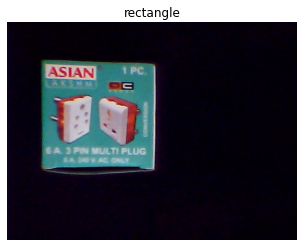

1/1 [==============================] - 0s 25ms/step
[[0. 0. 1.]]
2


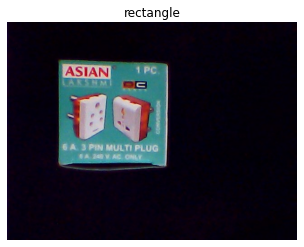

1/1 [==============================] - 0s 18ms/step
[[0. 1. 0.]]
1


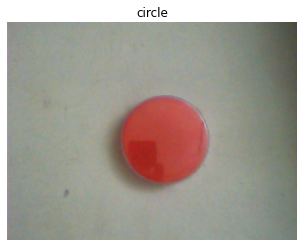

1/1 [==============================] - 0s 17ms/step
[[0. 1. 0.]]
1


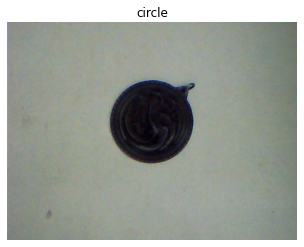

1/1 [==============================] - 0s 31ms/step
[[0.00000e+00 5.19504e-09 1.00000e+00]]
2


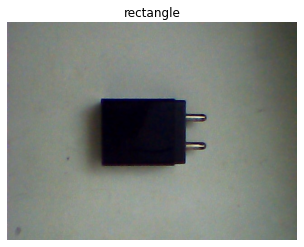

1/1 [==============================] - 0s 17ms/step
[[0. 0. 1.]]
2


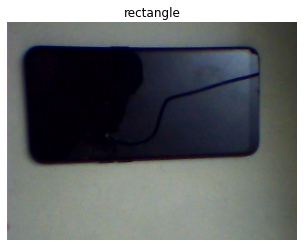

1/1 [==============================] - 0s 16ms/step
[[0. 0. 1.]]
2


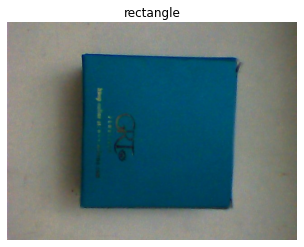

1/1 [==============================] - 0s 19ms/step
[[0. 0. 1.]]
2


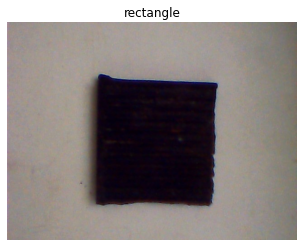

1/1 [==============================] - 0s 20ms/step
[[0. 1. 0.]]
1


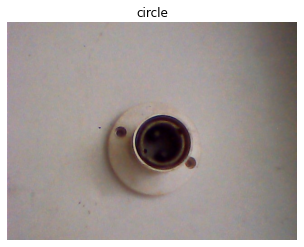

1/1 [==============================] - 0s 16ms/step
[[1. 0. 0.]]
0


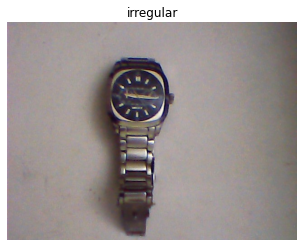

1/1 [==============================] - 0s 19ms/step
[[1. 0. 0.]]
0


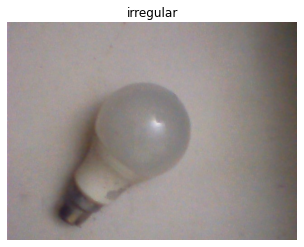

1/1 [==============================] - 0s 18ms/step
[[1. 0. 0.]]
0


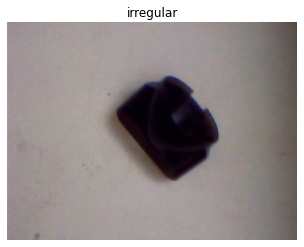

1/1 [==============================] - 0s 19ms/step
[[0. 0. 1.]]
2


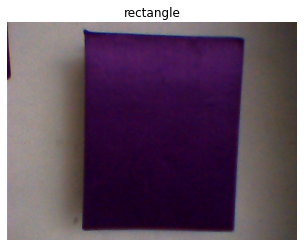

1/1 [==============================] - 0s 18ms/step
[[0. 0. 1.]]
2


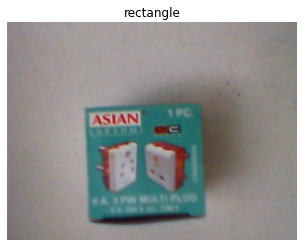

1/1 [==============================] - 0s 17ms/step
[[0. 1. 0.]]
1


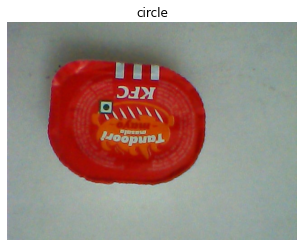

1/1 [==============================] - 0s 17ms/step
[[1. 0. 0.]]
0


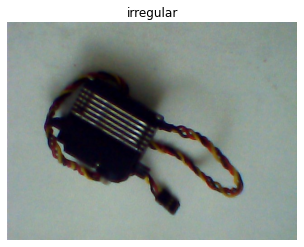

1/1 [==============================] - 0s 19ms/step
[[1. 0. 0.]]
0


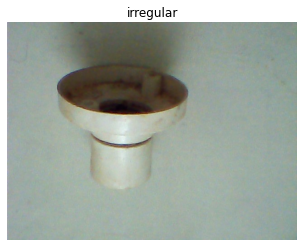

1/1 [==============================] - 0s 22ms/step
[[1. 0. 0.]]
0


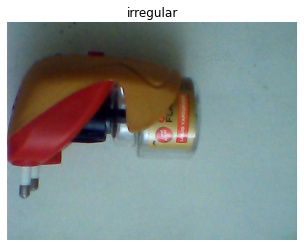

1/1 [==============================] - 0s 23ms/step
[[0. 1. 0.]]
1


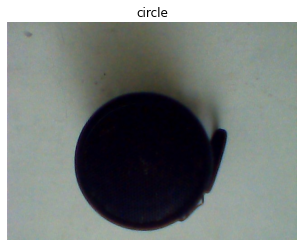

1/1 [==============================] - 0s 17ms/step
[[0. 1. 0.]]
1


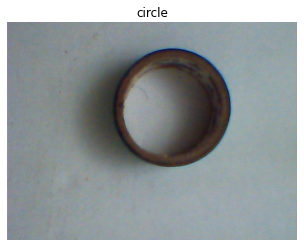

In [32]:
val='img'
for image_filename in os.listdir(val):
    img = imread(val+'/'+image_filename)
    para_img= imread(val+'/'+image_filename)
    img  = tf.convert_to_tensor(np.asarray(para_img))
    #img = tf.image.resize(img,(480, 640))
    img=img.numpy()
    pred=model.predict(img.reshape(1,480, 640,3)) 
    res=np.argmax(pred)
    print(pred)
    print(res)
    output=classes[np.argmax(pred)]
    plt.title(output)
    plt.axis("off")
    plt.imshow(img,cmap='gray')
    plt.show()

Pretrained

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests


image = Image.open('train\circle\WIN_20231105_21_44_17_Pro.jpg')

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
